## Introduction to Q-learning with OpenAI Gym
This is a step-by-step guide to using Q-learning in a simple OpenAI gym environment.

The notebook is based on https://github.com/gelanat/reinforcement-learning/blob/ba523383ef3e9de270eb1fd4d46b475d716a2274/Q-learning.ipynb

### Table of Contents

#### [Setup and Environment](#Setup_and_Environment)
- in this section, we download and examine the environment after importing all the necessary libraries;

#### [Q-learning](#Q-learning)
- in this section, we use Q-learning to solve the Taxi problem.


## Setup and Environment <a name='Setup_and_Environment'></a>

1. Install the necessary packages and libraries;
2. Set up the Taxi environment;
3. Determine the state and action space for our Q-table.

In [14]:
import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn as sns


In [15]:
# Fixing seed for reproducibility
np.random.seed(0) 

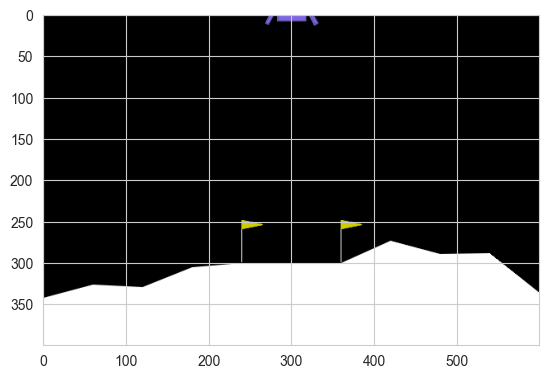

In [16]:
# Loading and rendering the gym environment
#env = gym.make("Taxi-v3", render_mode="human")
env = gym.make("LunarLander-v3", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.show()

In [17]:
#Getting the state space
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(4)
State Space Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


## Q-learning

1. initialize our Q-table given the state and action space in STEP 1;
    - choose the hyperparameters for training;
2. choose an action: explore or exploit in STEP 2;
3. perform the action and measure the reward in STEPs 3 & 4;
4. ^^
5. update the Q-table using the Bellman equation in STEP 5.
    - update the collected rewards
    - use decay to balance exploration and exploitation

In [18]:
#Setting the hyperparameters

max_epsilon = 1
min_epsilon = 0.01
decay = 0.01

train_episodes = 2000
test_episodes = 100          
max_steps = 100

n_bins = 8

In [21]:
# Class for the agent

class QLearner:
    def __init__(self, env, n_bins):
        self.env = env
        self.n_bins = n_bins
        self.bins = []
        # self.Q = np.zeros((n_states, n_actions))
        self.alpha = 0.8 # learning rate (can be set to a constant instead of a function)
        self.discount_factor = 0.7
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        for low, high in zip(self.env.observation_space.low, self.env.observation_space.high):
            if np.isinf(low) or np.isinf(high):
                low, high = -1, 1
            self.bins.append(np.linspace(low, high, self.n_bins-1))

        self.state_shape = tuple([self.n_bins] * self.env.observation_space.shape[0])
        self.Q = np.zeros(self.state_shape + (self.env.action_space.n,))

    def discretize_state(self, obs):
        state = []
        for i in range(len(obs)):
            bin_idx = np.digitize(obs[i], self.bins[i])
            state.append(min(bin_idx, self.n_bins - 1))  # ensure it's within bounds
        return tuple(state)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[state])

    def update_Q(self, state, new_state, action, reward):
        best_future_q = np.max(self.Q[new_state])
        td_target = reward + self.discount_factor * best_future_q
        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


#STEP 1 - Initializing the Q-table
agent = QLearner(env, n_bins)

In [22]:
#Training the agent

#Creating lists to keep track of reward and epsilon values
training_rewards = []  
epsilons = []

def train_agent():
    for episode in range(train_episodes):
        # Reseting the environment each time as per requirement
        state, info = env.reset()
        state = agent.discretize_state(state)
        # Starting the tracker for the rewards
        total_training_rewards = 0

        for step in range(100):
            action = agent.choose_action(state)
            ### STEPs 3 & 4: performing the action and getting the reward
            # Taking the action and getting the reward and outcome state
            new_state, reward, terminated, truncated, info = env.step(action)
            new_state = agent.discretize_state(new_state)

            agent.update_Q(state, new_state, action, reward)
            total_training_rewards += reward
            state = new_state

            # Ending the episode
            if terminated or truncated:
                # print ("Total reward for episode {}: {}".format(episode, total_training_rewards))
                break

        # Cutting down on exploration by reducing the epsilon
        agent.epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay*episode)

        # Adding the total reward and reduced epsilon values
        training_rewards.append(total_training_rewards)
        epsilons.append(agent.epsilon)


train_agent()

print("Training score over time: " + str(sum(training_rewards)/train_episodes))

Training score over time: -9.849353460033482


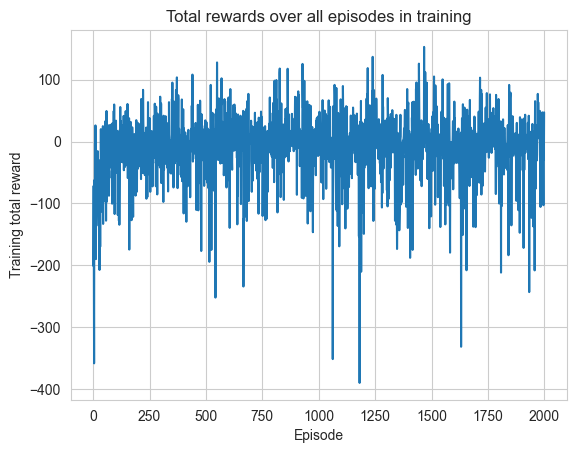

In [23]:
#Visualizing results and total reward over all episodes
x = range(train_episodes)
plt.plot(x, training_rewards)
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.show()

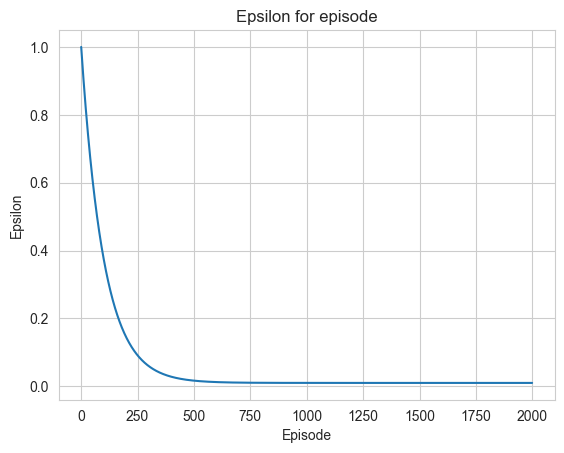

In [24]:
#Visualizing the epsilons over all episodes
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon for episode")
plt.show()

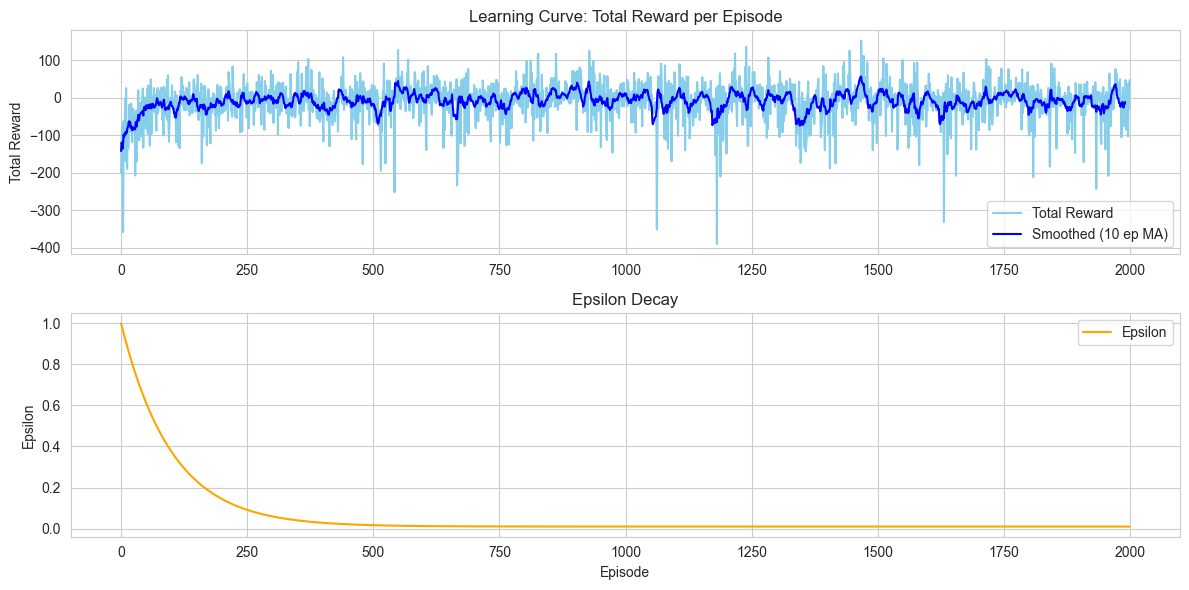

In [27]:
# Moving average helper
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot
plt.figure(figsize=(12, 6))

# Reward curve
plt.subplot(2, 1, 1)
plt.plot(training_rewards, color='skyblue', label='Total Reward')
plt.plot(moving_average(training_rewards), color='blue', label='Smoothed (10 ep MA)')
plt.title("Learning Curve: Total Reward per Episode")
plt.ylabel("Total Reward")
plt.legend()

# Epsilon decay
plt.subplot(2, 1, 2)
plt.plot(epsilons, color='orange', label='Epsilon')
plt.title("Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.legend()

plt.tight_layout()
plt.show()

step = 0


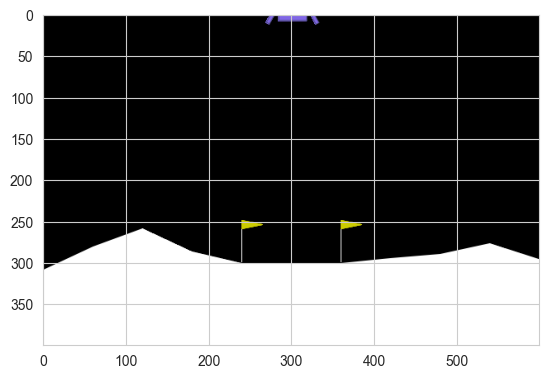

reward: 0.9331560647277126
step = 1


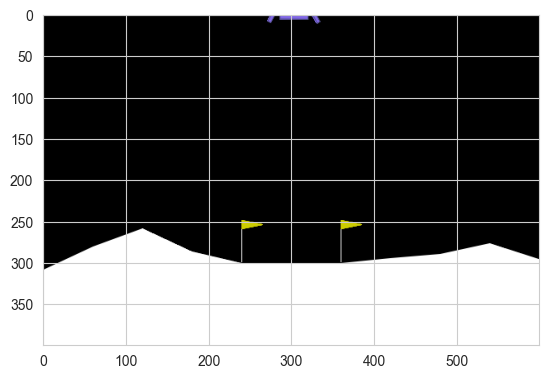

reward: 1.2118314621454556
step = 2


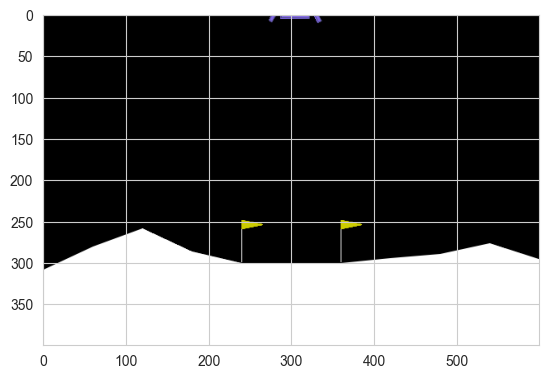

reward: 1.5765382885892063
step = 3


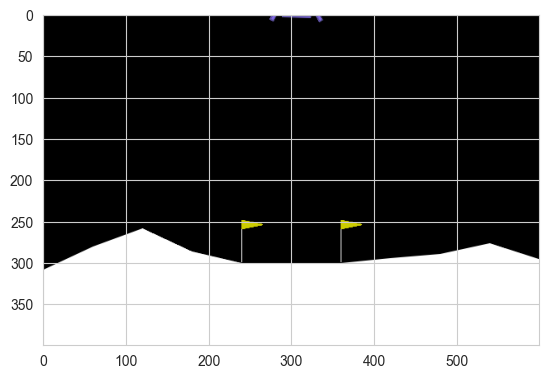

reward: 1.668220685069998
step = 4


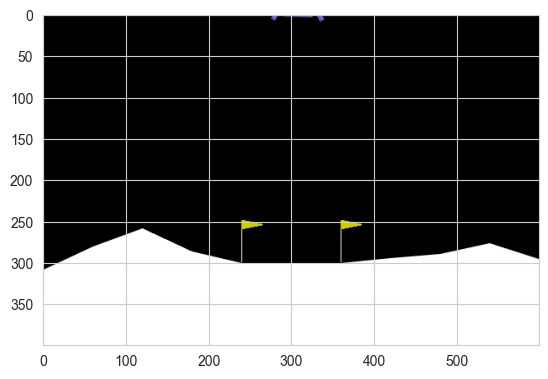

reward: 1.7201695966685133
step = 5


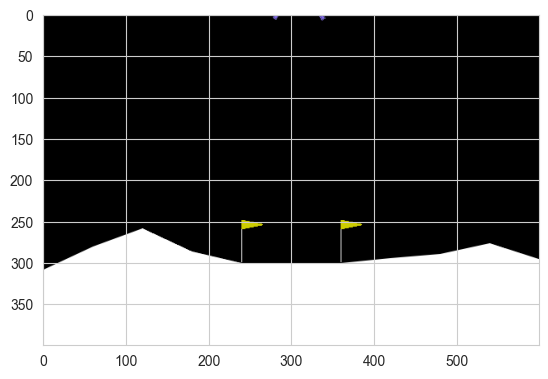

reward: 1.9526930916999004
step = 6


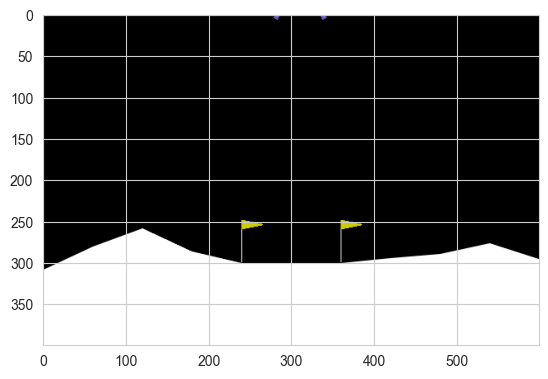

reward: 1.256049057320156
step = 7


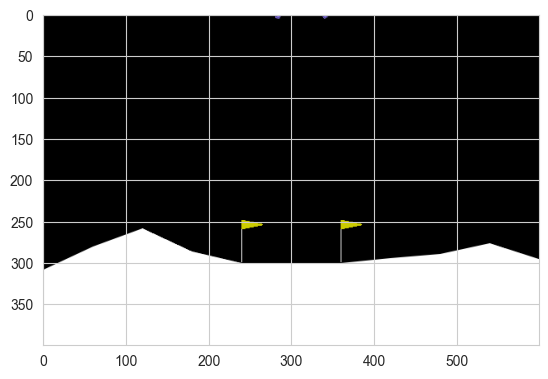

reward: 0.5912777038684294
step = 8


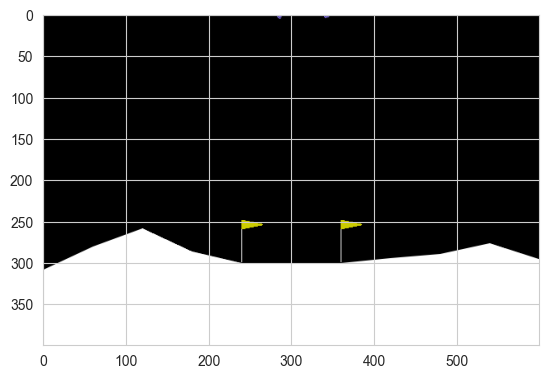

reward: 0.1914286453483112
step = 9


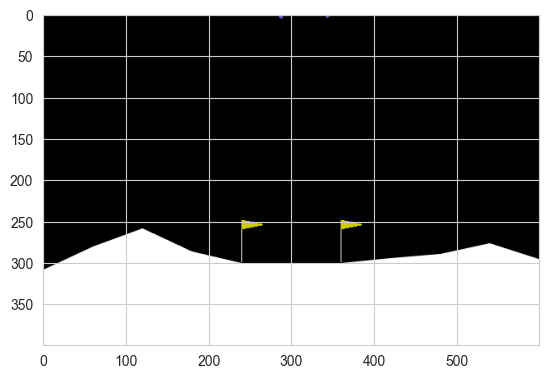

reward: 0.06838736573706797
step = 10


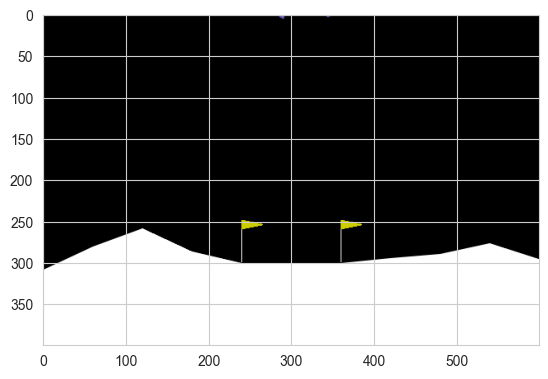

reward: -0.3481093272128237
step = 11


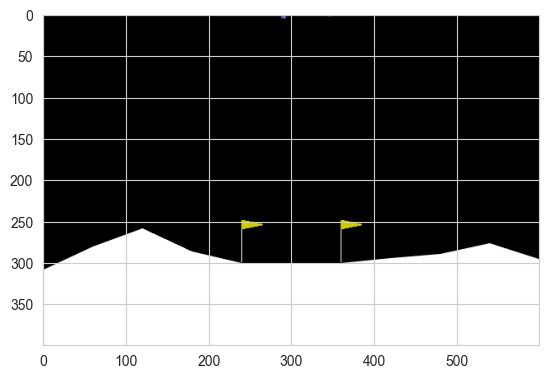

reward: -0.5055494217631054
step = 12


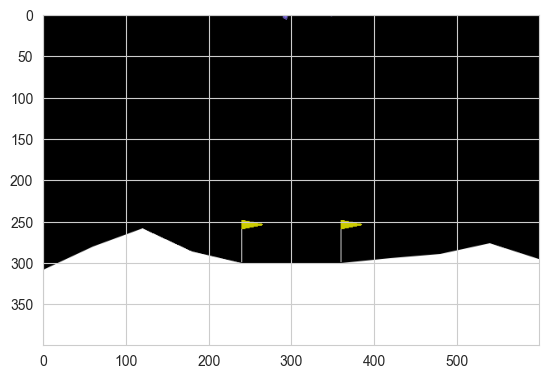

reward: -0.8806545270715265
step = 13


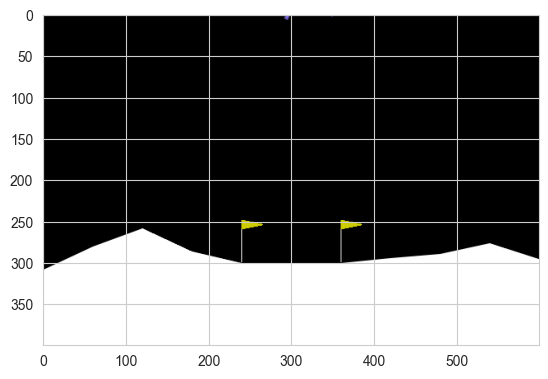

reward: -1.020726566287492
step = 14


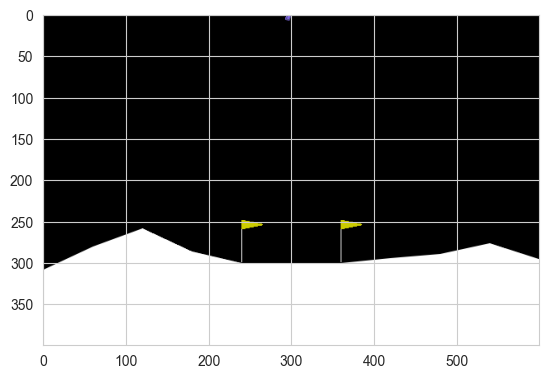

reward: -0.2876235083239635
step = 15


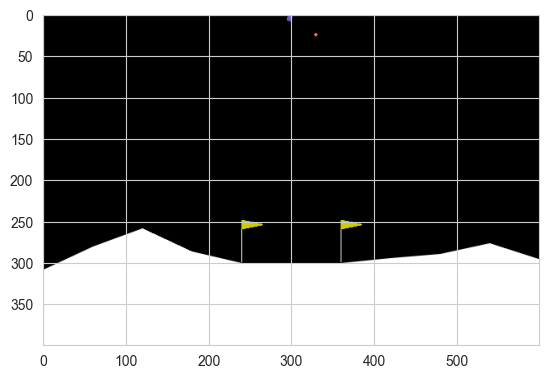

reward: -1.138296707585339
step = 16


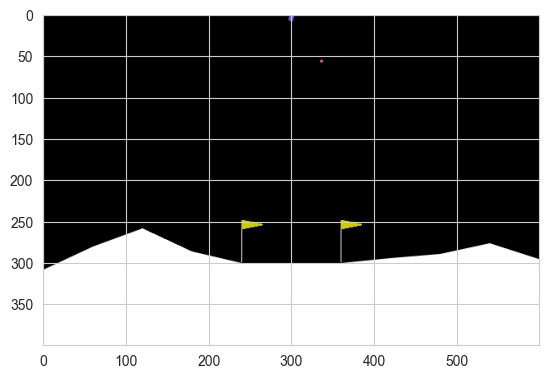

reward: -0.4166634220090543
step = 17


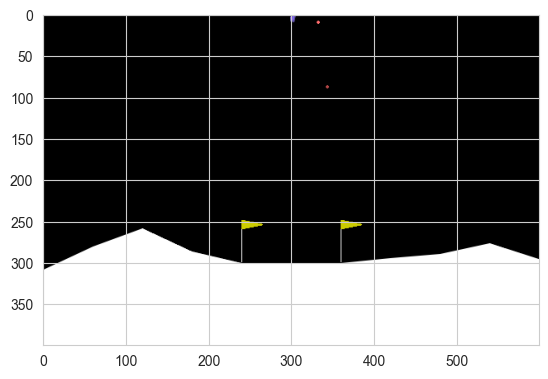

reward: -1.7307621672230755
step = 18


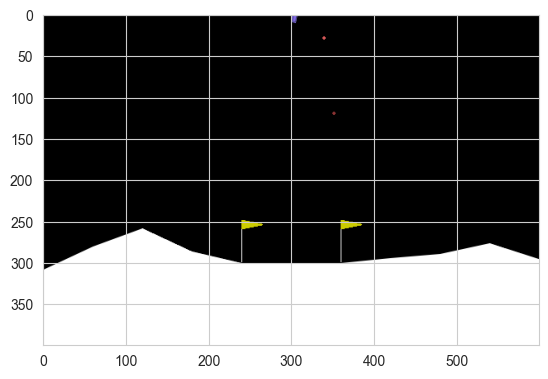

reward: -3.221135922305751
step = 19


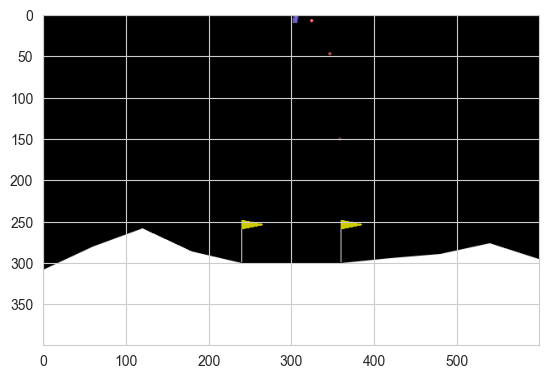

reward: -2.2365144439309743
step = 20


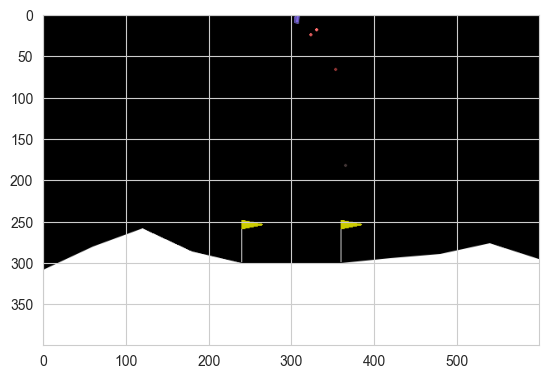

reward: -1.7152461288352459
step = 21


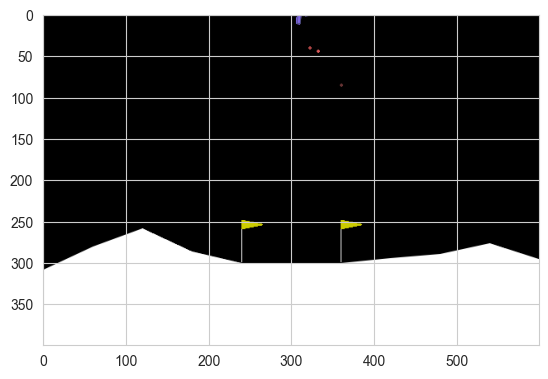

reward: -2.1544033590066816
step = 22


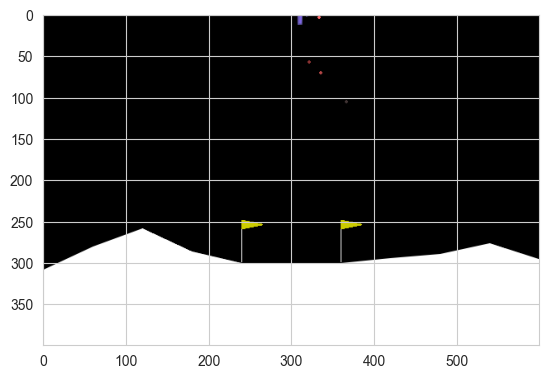

reward: -0.4338384613299297
step = 23


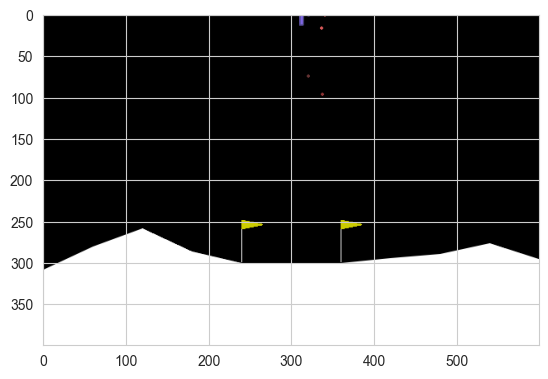

reward: -1.5756962026146255
step = 24


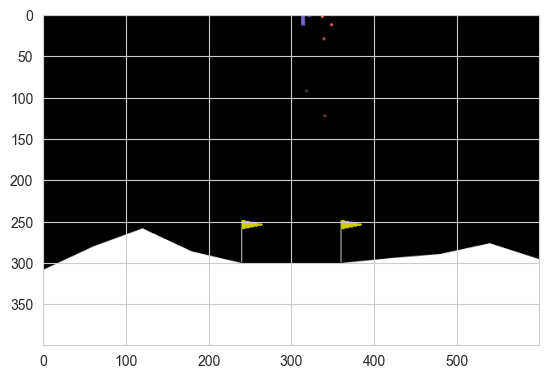

reward: -1.123593460613182
step = 25


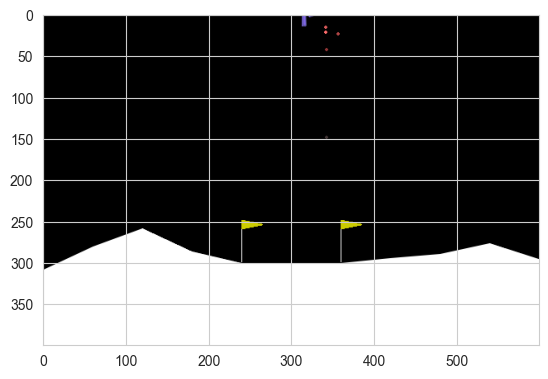

reward: -1.9967665056788337
step = 26


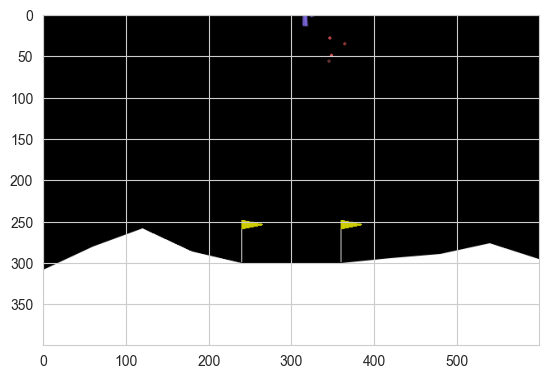

reward: -2.504651140883253
step = 27


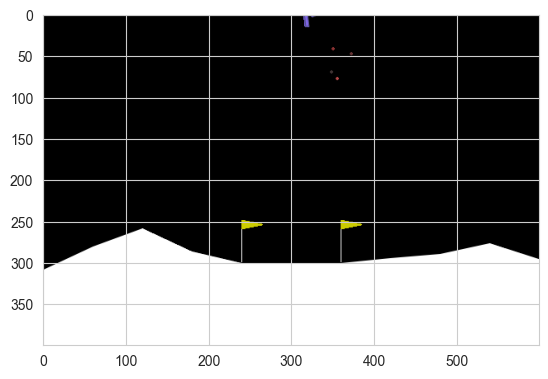

reward: -1.275486400383801
step = 28


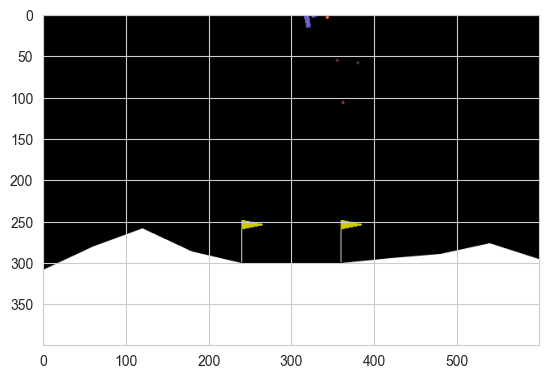

reward: 1.871299706406586
step = 29


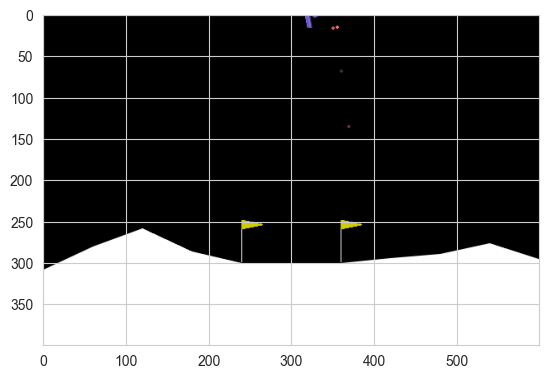

reward: 0.11536648742885519
step = 30


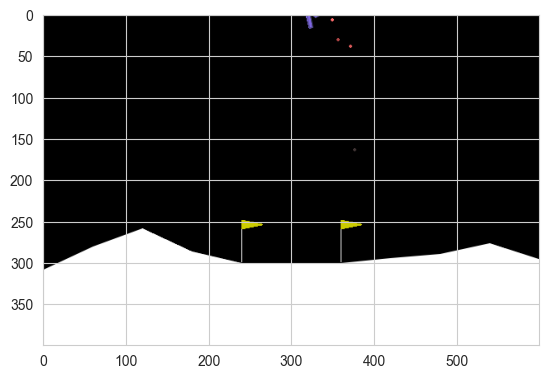

reward: -2.7660919154937162
step = 31


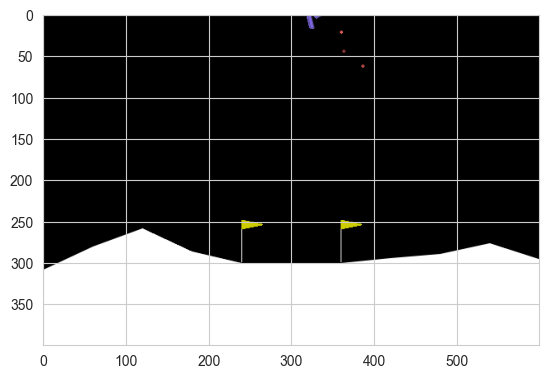

reward: 0.07733767123444296
step = 32


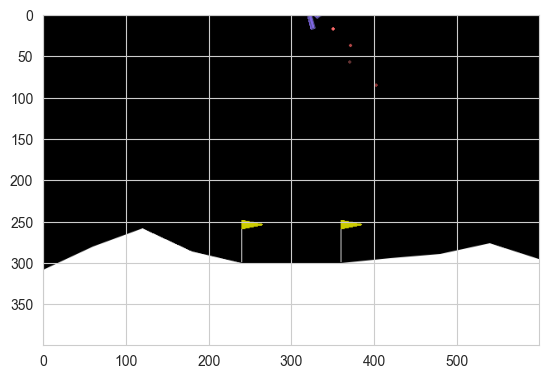

reward: -3.395021961817234
step = 33


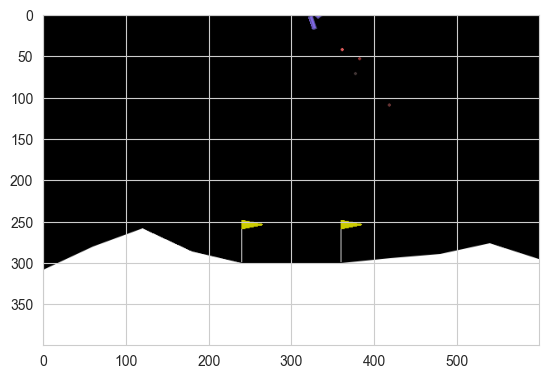

reward: 2.0862663131641854
step = 34


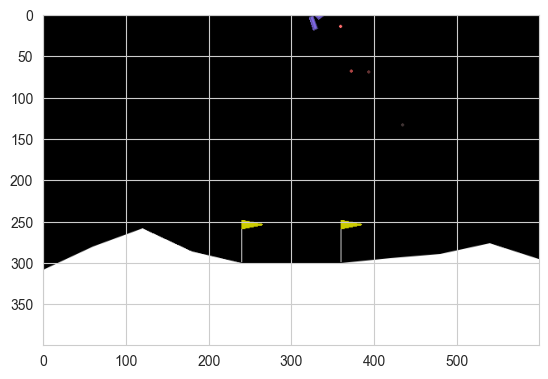

reward: -1.801072418279989
step = 35


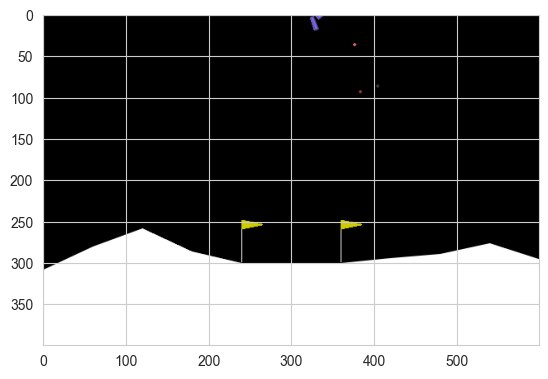

reward: -5.420353322681307
step = 36


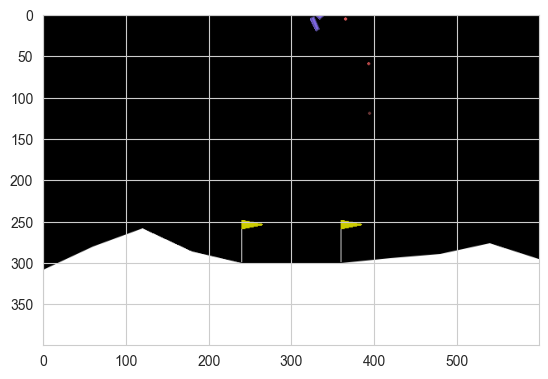

reward: -4.922349827770762
step = 37


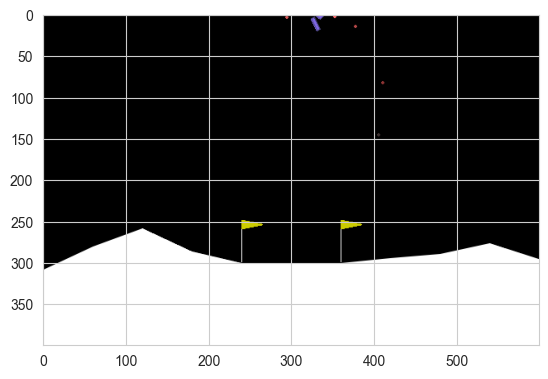

reward: -4.3408276983620615
step = 38


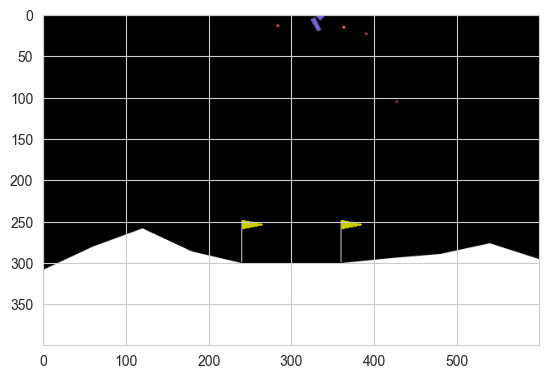

reward: -4.696030527265804
step = 39


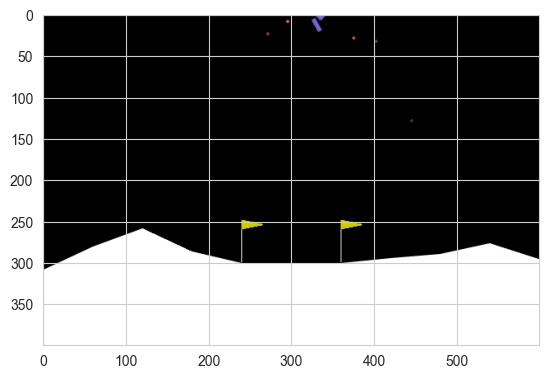

reward: -4.294928799318739
step = 40


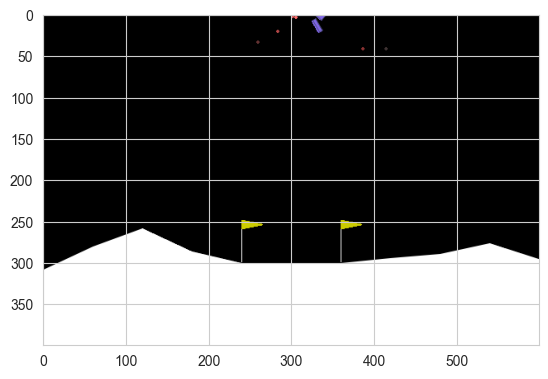

reward: -4.1151965452733625
step = 41


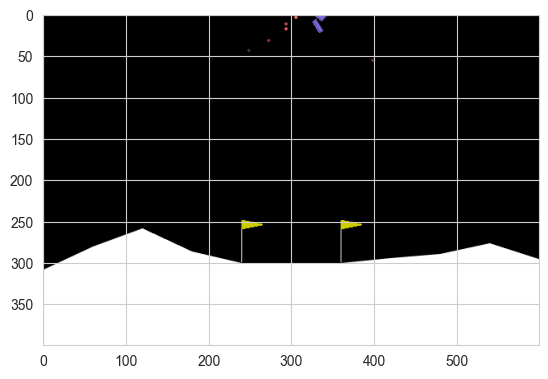

reward: -4.01324721006216
step = 42


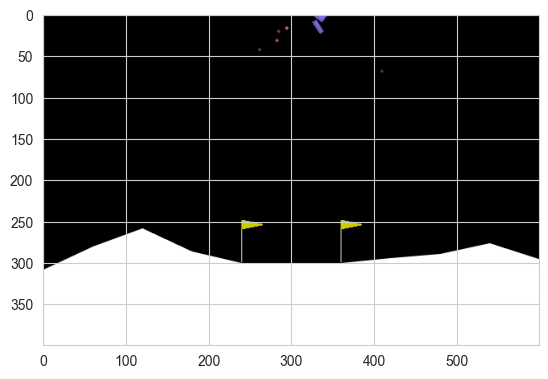

reward: -2.240900734083925
step = 43


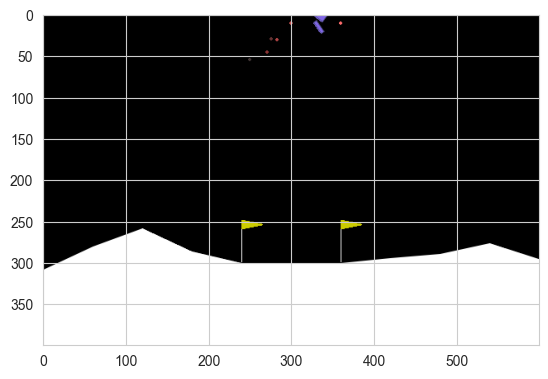

reward: -3.483534330827949
step = 44


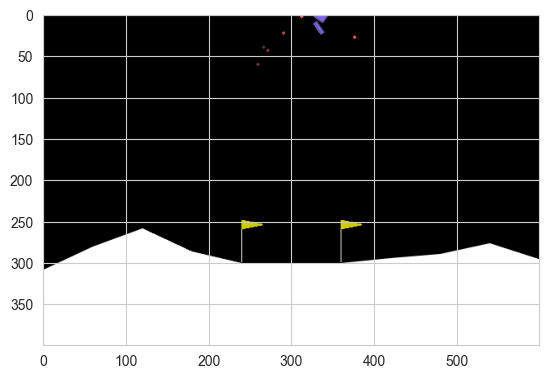

reward: -3.0069113562445566
step = 45


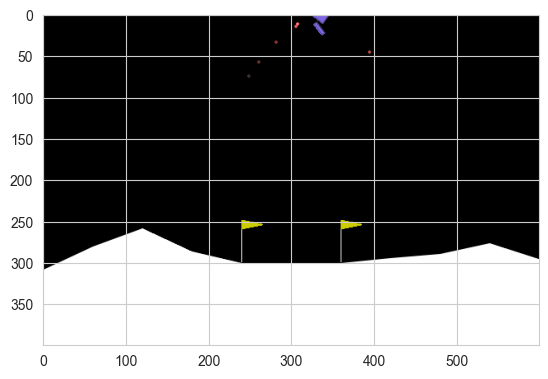

reward: -3.1065465992133725
step = 46


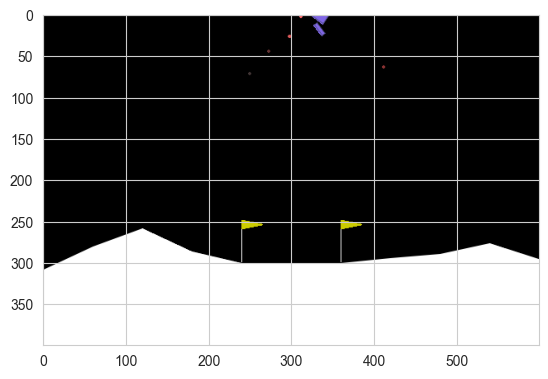

reward: -2.914253193856068
step = 47


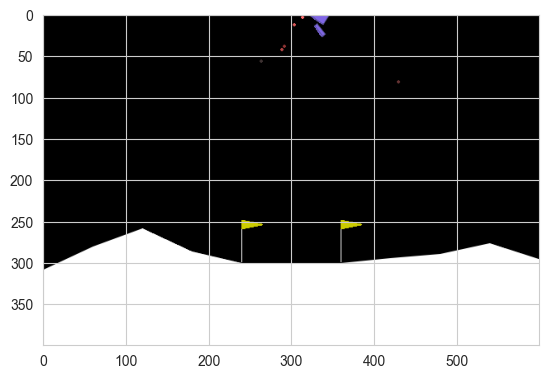

reward: -2.580103522111044
step = 48


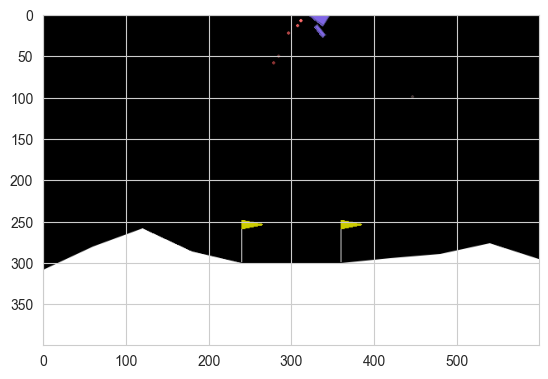

reward: -2.453131495599307
step = 49


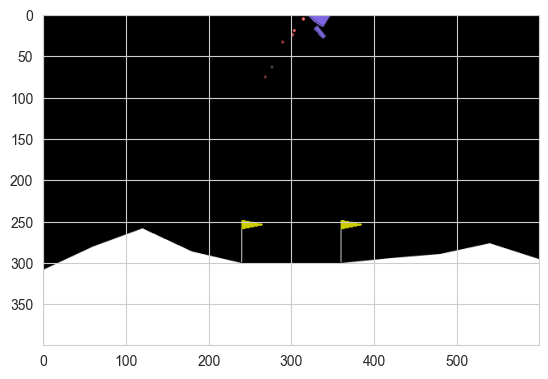

reward: -2.0245421202976375
step = 50


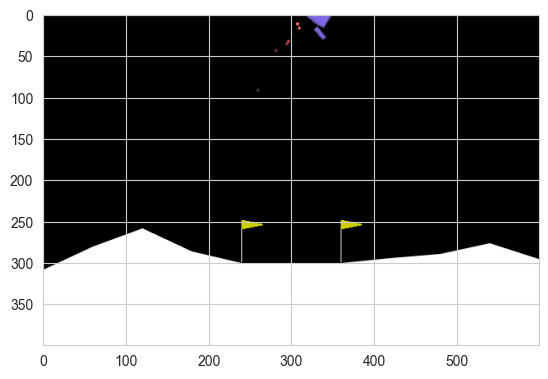

reward: -1.857894401985759
step = 51


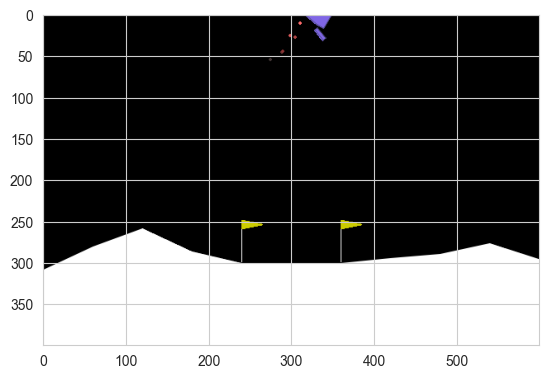

reward: -1.6192752902544203
step = 52


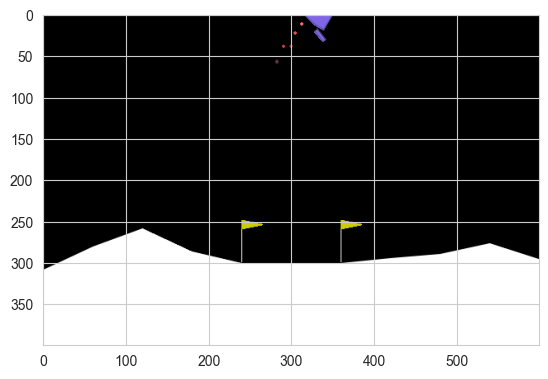

reward: -1.2441241071684022
step = 53


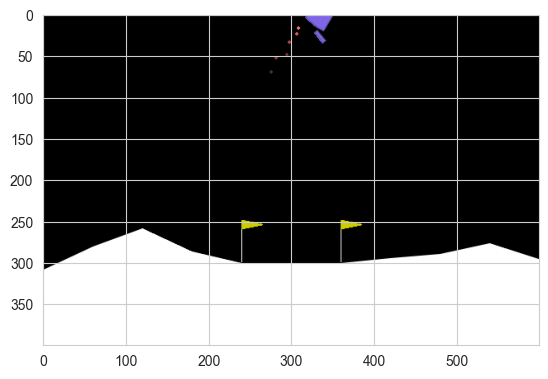

reward: -0.8341361218910197
step = 54


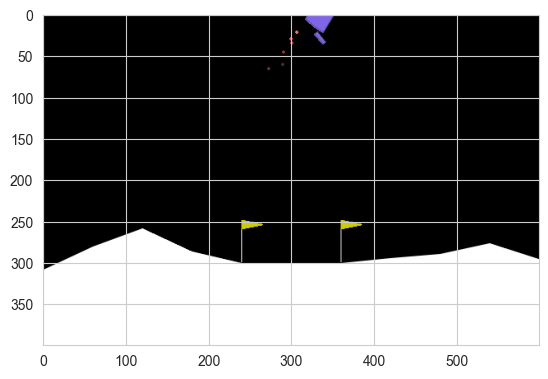

reward: -0.4925887466842187
step = 55


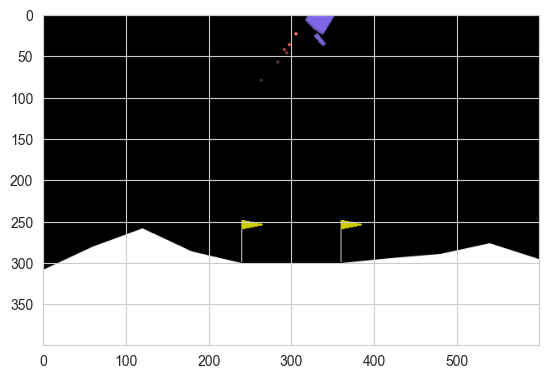

reward: 0.6677151309244891
step = 56


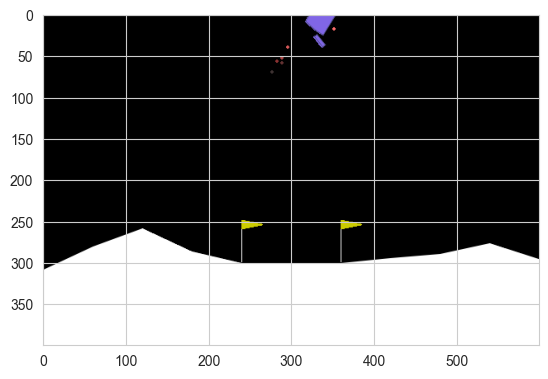

reward: -0.15855718521581139
step = 57


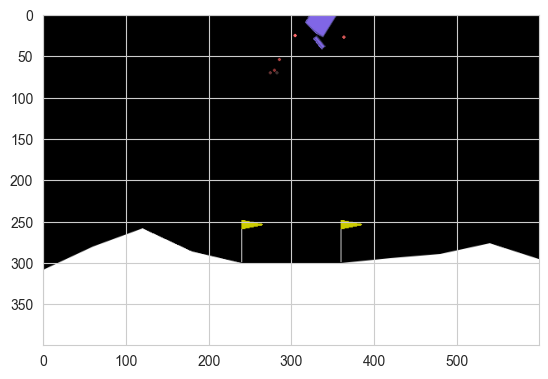

reward: 0.03665672955017499
step = 58


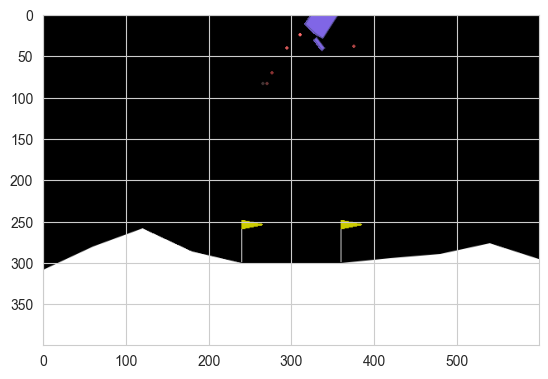

reward: 0.10388052922528004
step = 59


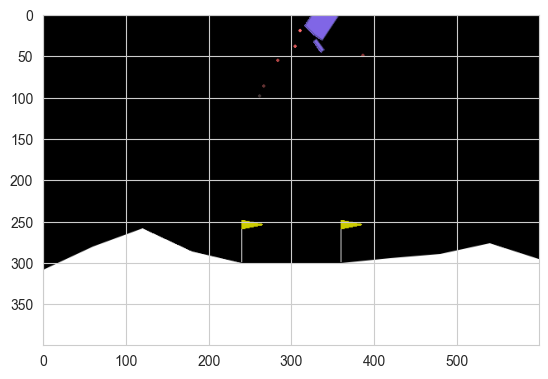

reward: 0.5240489263146355
step = 60


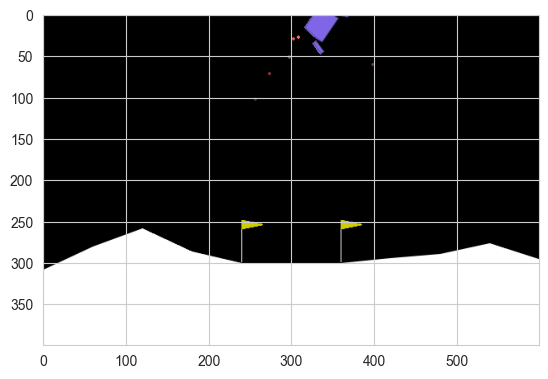

reward: 0.9391222572832885
step = 61


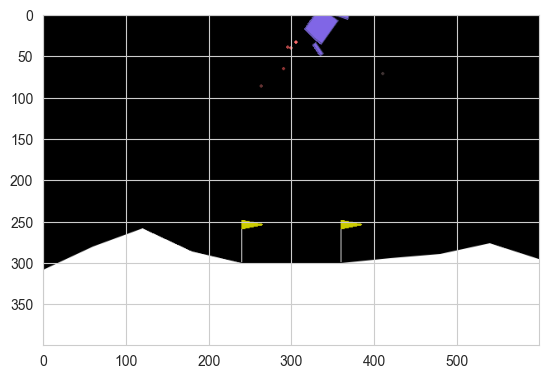

reward: 1.0872688302477809
step = 62


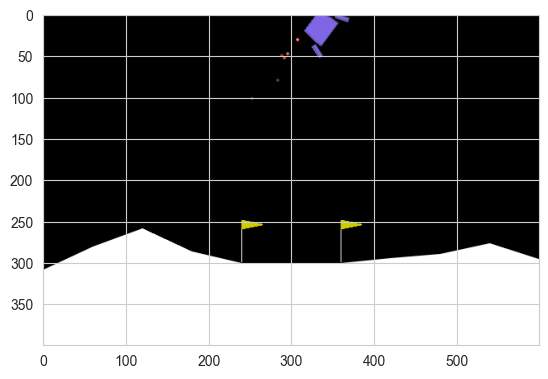

reward: 2.8234667132814026
step = 63


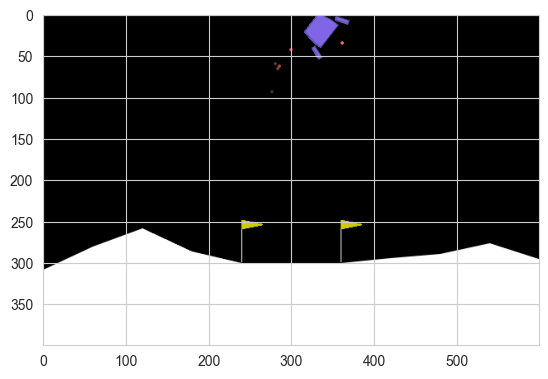

reward: 1.368886941550586
step = 64


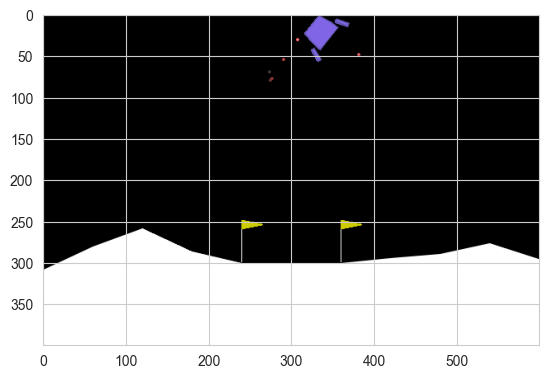

reward: 1.9053078088549296
step = 65


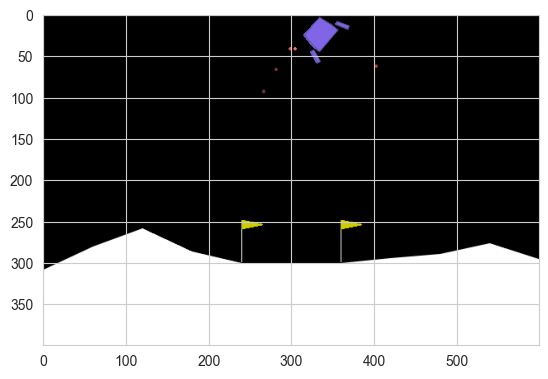

reward: 1.899609315134826
step = 66


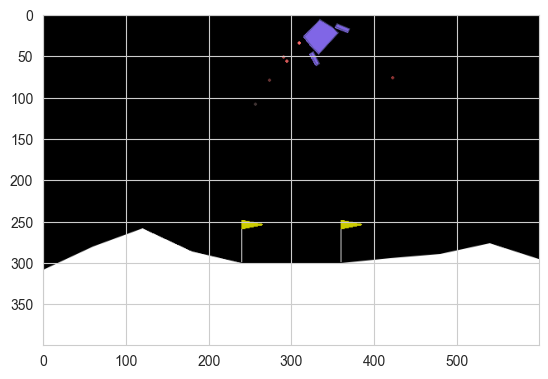

reward: 2.3873843413220768
step = 67


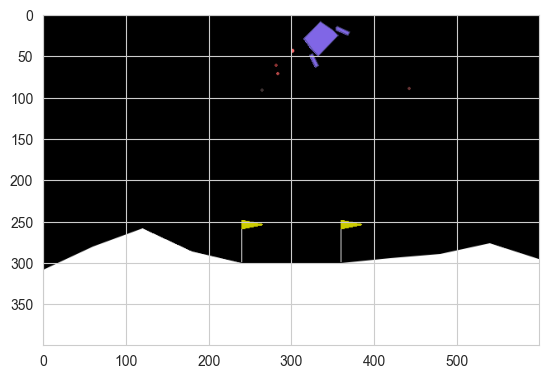

reward: 2.628339874152489
step = 68


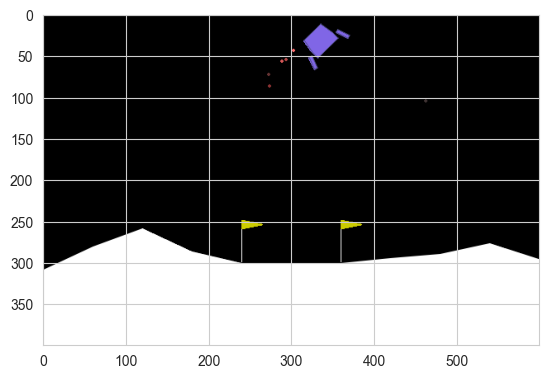

reward: 2.8418472166191875
step = 69


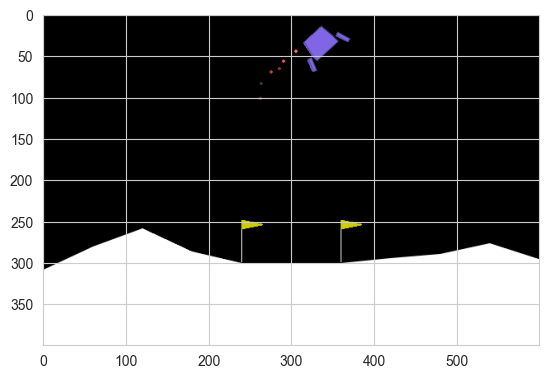

reward: 3.166801868088983
step = 70


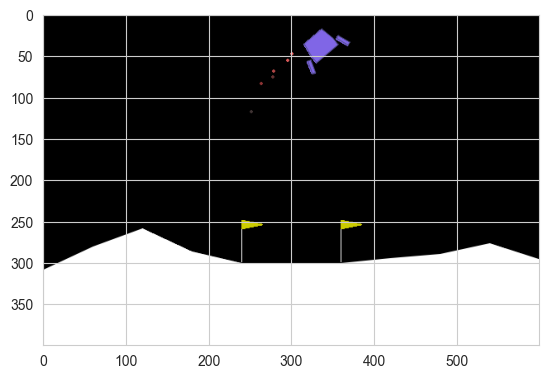

reward: 3.272182308000852
step = 71


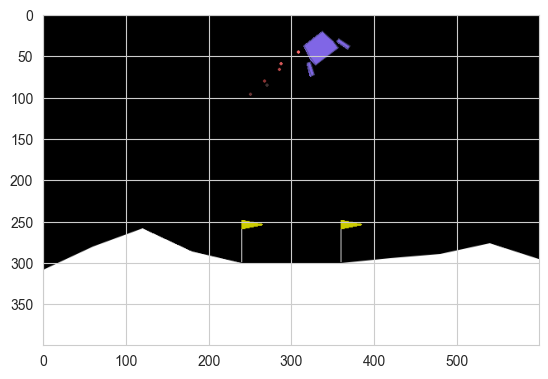

reward: 3.373958457110662
step = 72


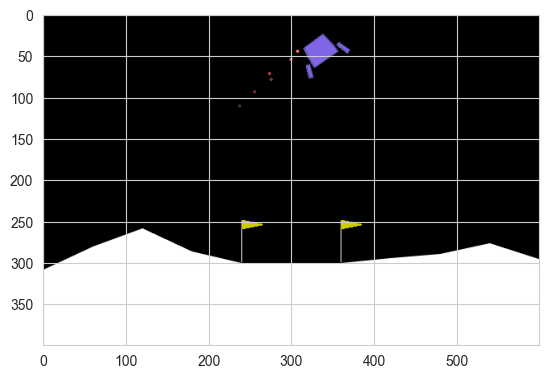

reward: 7.6424842962955895
step = 73


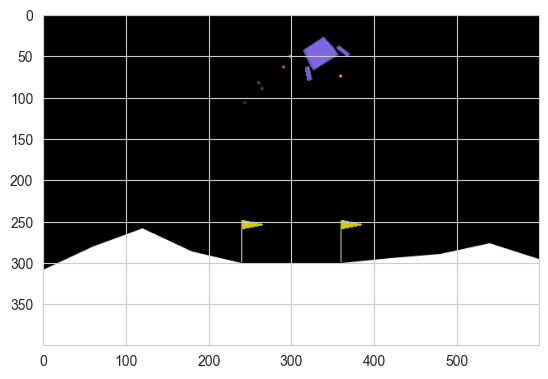

reward: 3.8164737423862234
step = 74


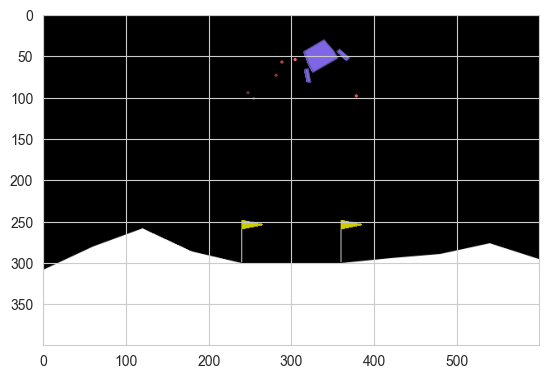

reward: 4.128387341710835
step = 75


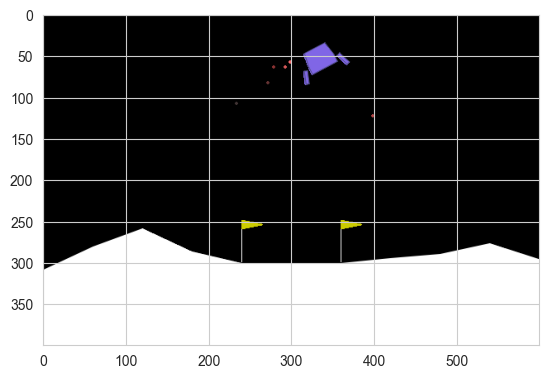

reward: 4.239150558220161
step = 76


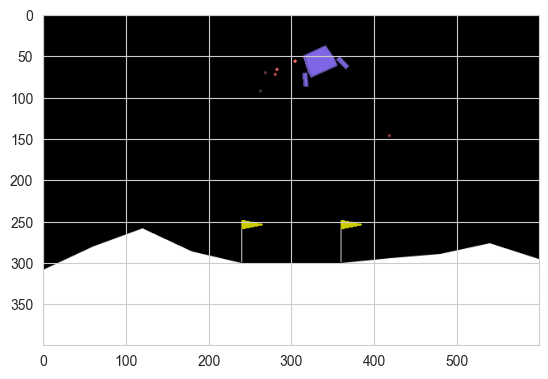

reward: 4.559856137393155
step = 77


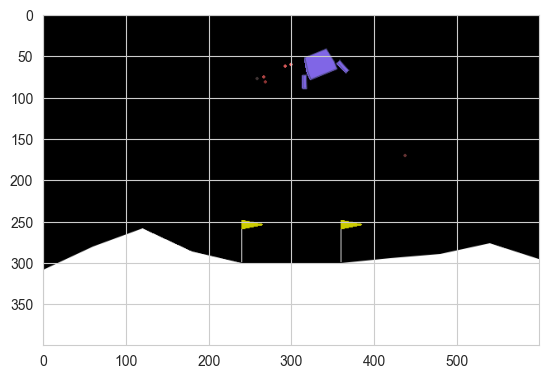

reward: 4.766034046915395
step = 78


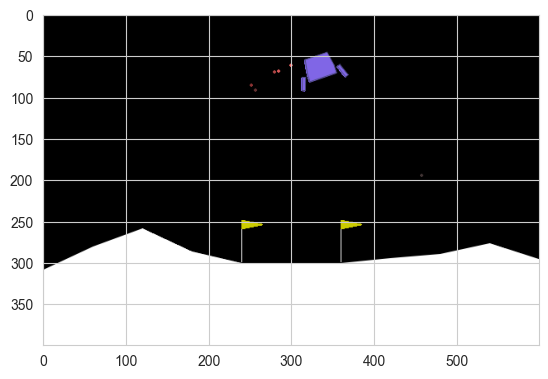

reward: 4.9892418948513475
step = 79


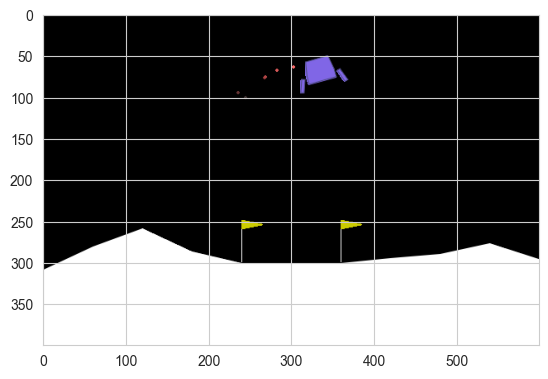

reward: 5.17036300735444
step = 80


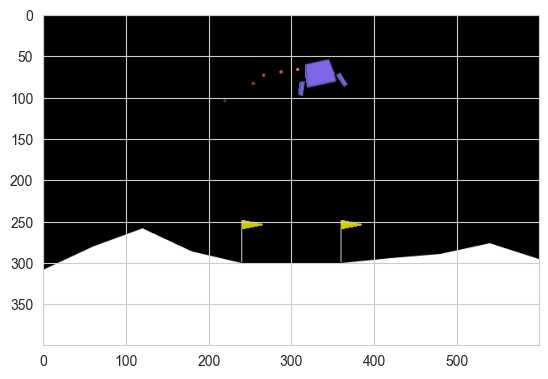

reward: 10.455402738442682
step = 81


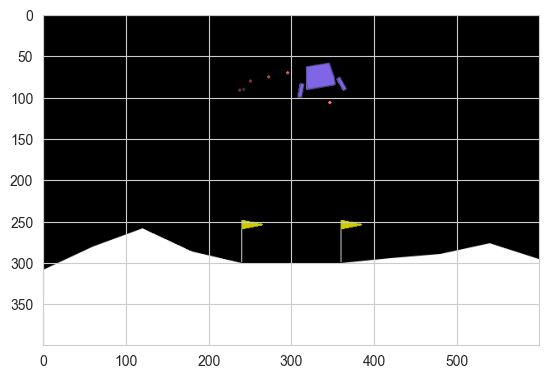

reward: 5.276113964668839
step = 82


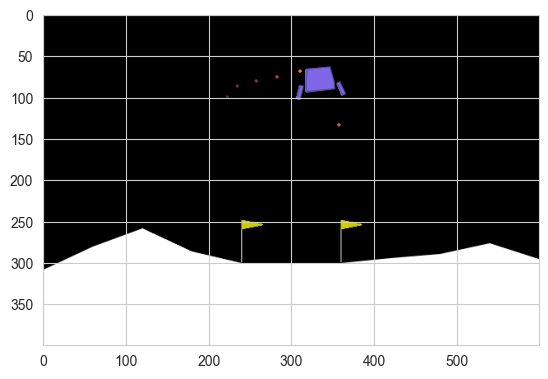

reward: 5.537690977250436
step = 83


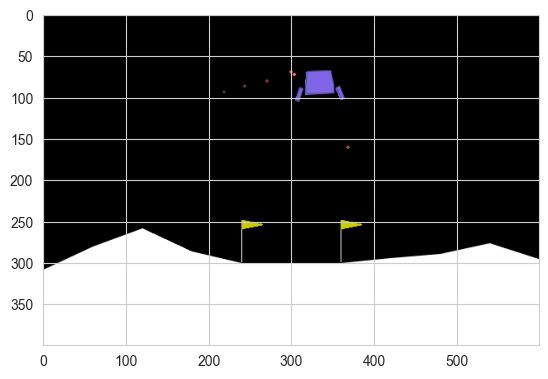

reward: 0.09254044264324193
step = 84


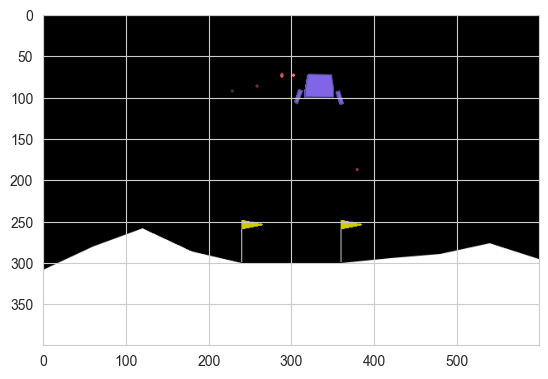

reward: -4.207979693620376
step = 85


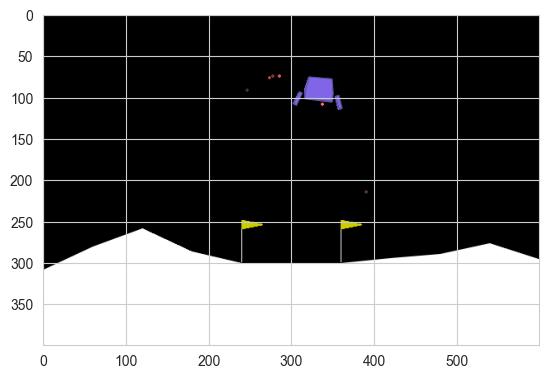

reward: -4.6560905440788245
step = 86


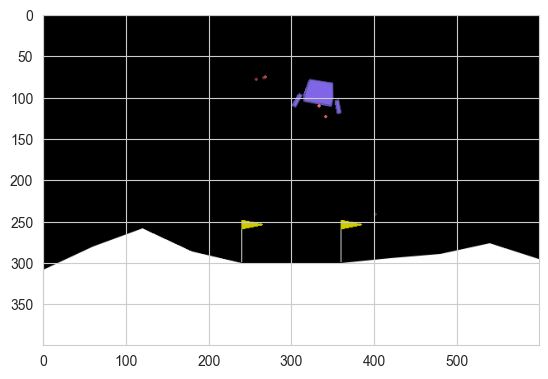

reward: -1.007007080418606
step = 87


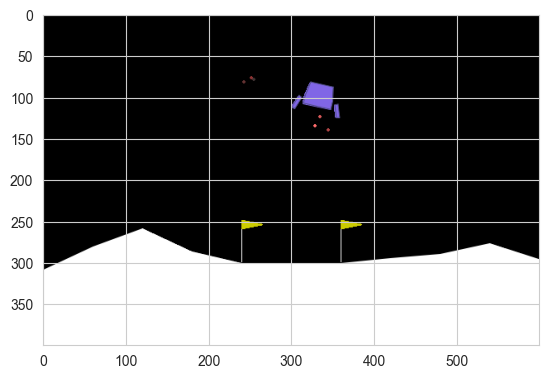

reward: -2.9316854485765473
step = 88


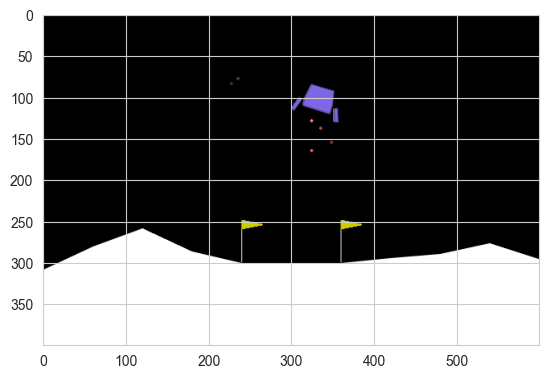

reward: -6.872317018068599
step = 89


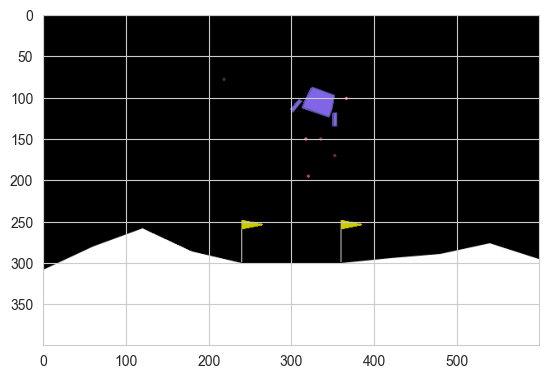

reward: -6.61380322847799
step = 90


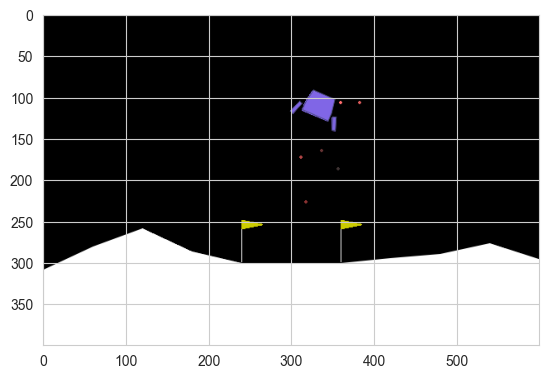

reward: -2.1074314013812225
step = 91


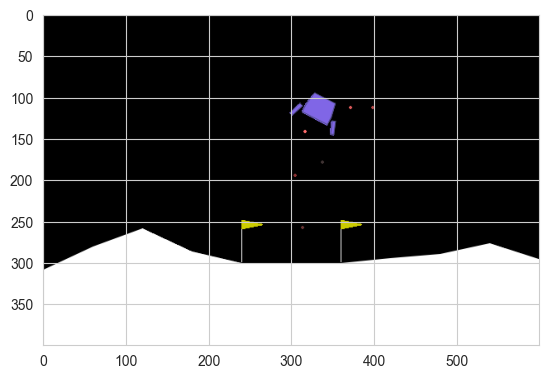

reward: -6.245770368181836
step = 92


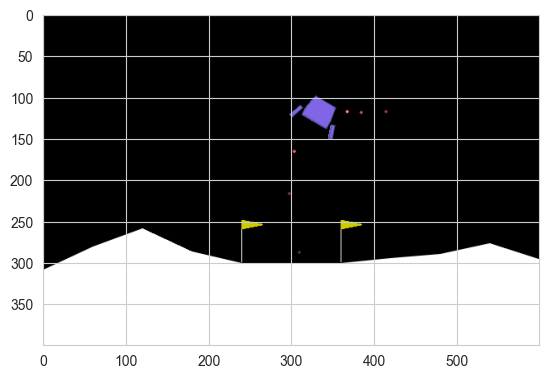

reward: -6.026390708668429
step = 93


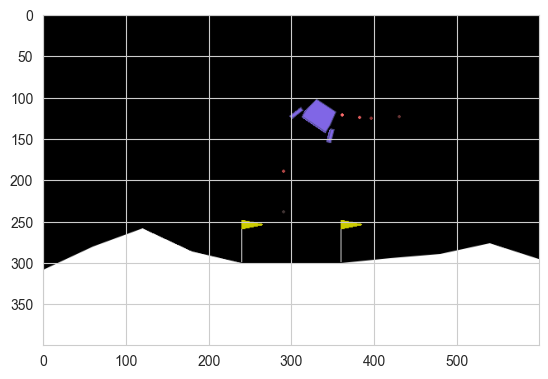

reward: -5.762951528494567
step = 94


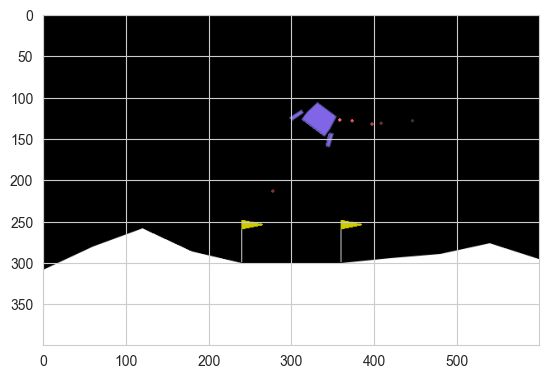

reward: -5.374165657071358
step = 95


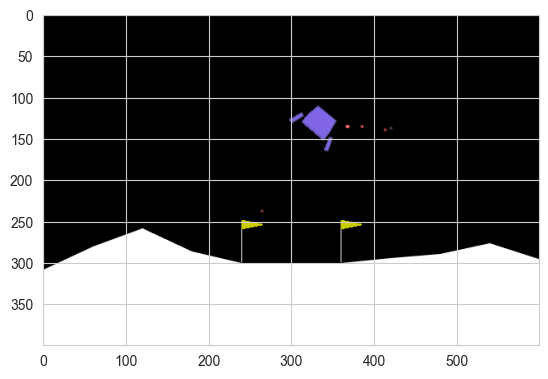

reward: -4.9595232354222665
step = 96


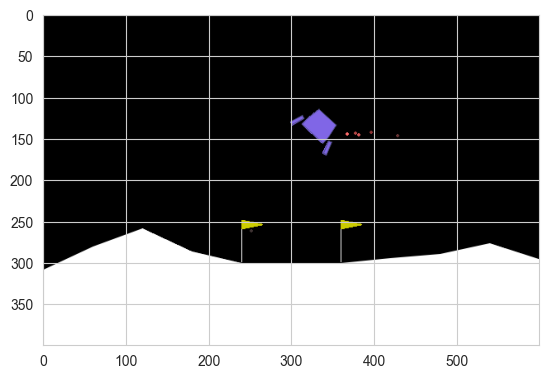

reward: -2.4814337385883958
step = 97


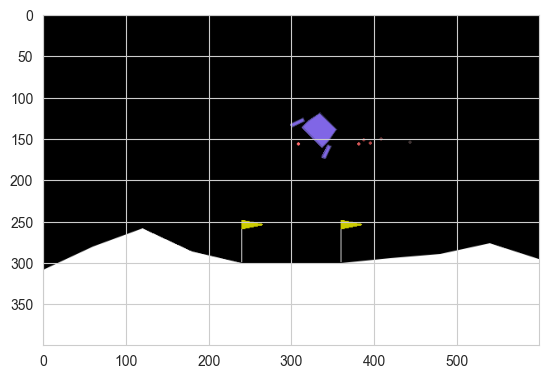

reward: -4.832772456449248
step = 98


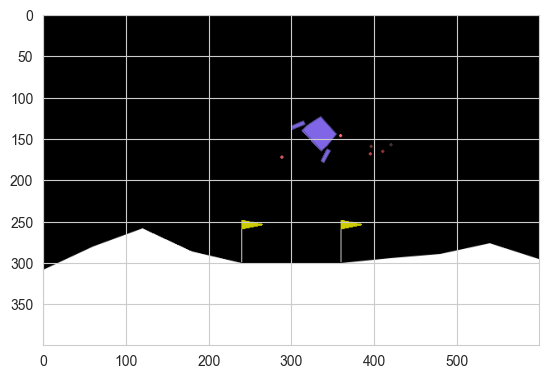

reward: -4.337717354495481
step = 99


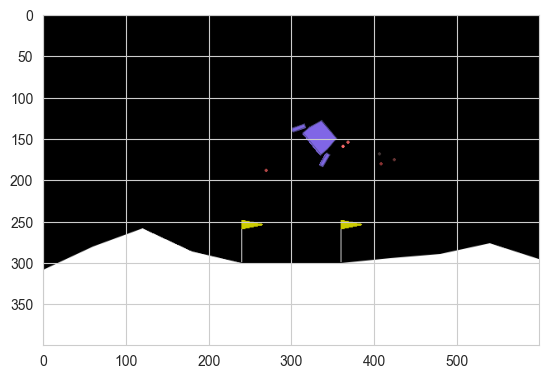

reward: -4.056338432491912


In [26]:
import time

def showcase_agent():
    state, info = env.reset()
    state = agent.discretize_state(state)
    total_rewards = 0.0
    agent.epsilon = 0.0 # we don't want random actions here
    for step in range(100):
        print(f"step = {step}")
        plt.imshow(env.render())
        plt.show()
        time.sleep(0.1)
        action = agent.choose_action(state)
        new_state, reward, terminated, truncated, info = env.step(action)
        new_state = agent.discretize_state(new_state)
        print(f"reward: {reward}")
        total_rewards += reward
        state = new_state

        #Ending the episode
        if terminated or truncated:
            print("game finished!")
            print(f"Total reward: {total_rewards}")
            break
    env.close()

showcase_agent()